# Script 03: Analysis of the ML results
We load the results of the 5 folds of the nested cross-validation and inspect the performance (precision-recall curve) and analyze the output with SHAP.

We are discussing the results in our upcoming paper.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

#pd.options.display.max_rows = 100
#pd.options.display.min_rows = 100

In [2]:
import pandas as pd
import numpy as np

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import (recall_score, precision_score, f1_score, explained_variance_score, mean_squared_error,
                            mean_absolute_error, r2_score, confusion_matrix, roc_auc_score, average_precision_score,
                            accuracy_score, plot_confusion_matrix, precision_recall_curve, auc)

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import pickle

import shap

In [3]:
shap.initjs()

# Helper Functions and Classes

In [4]:
# for storing our results
class results:

    # parameterized constructor
    def __init__(self, search, y_test, y_test_predict, X_test, X_train, y_train, groups,
                 y_df, X_df, train_index, test_index, cnt, pipe, searchspace):
        self.search = search
        self.y_test = y_test
        self.y_test_predict = y_test_predict
        self.X_test = X_test
        self.X_train = X_train
        self.y_train = y_train
        self.groups = groups
        self.y_df = y_df
        self.X_df = X_df
        self.train_index = train_index
        self.test_index = test_index
        self.cnt = cnt
        self.pipe = pipe
        self.searchspace = searchspace

In [5]:
# https://stackoverflow.com/questions/11011756/is-there-any-pythonic-way-to-combine-two-dicts-adding-values-for-keys-that-appe

import operator
def combine_dicts(a, b, op=operator.add):
    return dict(list(a.items()) + list(b.items()) +
        [(k, op(a[k], b[k])) for k in set(b) & set(a)])

# Load results

In [6]:
res1 = pickle.load(open('results/2022-07-15-15-03-01-porno-pipeline-fold-1.pkl', 'rb'))
res2 = pickle.load(open('results/2022-07-15-15-22-38-porno-pipeline-fold-2.pkl', 'rb'))
res3 = pickle.load(open('results/2022-07-15-15-42-01-porno-pipeline-fold-3.pkl', 'rb'))
res4 = pickle.load(open('results/2022-07-15-16-01-26-porno-pipeline-fold-4.pkl', 'rb'))
res5 = pickle.load(open('results/2022-07-15-16-22-18-porno-pipeline-fold-5.pkl', 'rb'))

rl = [res1, res2, res3, res4, res5]

In [7]:
# example GridSearchCV result
rl[0].search

GridSearchCV(cv=StratifiedGroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('maxabs', MaxAbsScaler()),
                                       ('lgbm', LGBMClassifier(silent=True))]),
             n_jobs=-1,
             param_grid=[{'lgbm__deterministic': [True],
                          'lgbm__force_row_wise': [True],
                          'lgbm__learning_rate': [0.01, 0.1, 0.2, 0.3],
                          'lgbm__max_depth': [-1, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12],
                          'lgbm__n_estimators': [25, 50, 100, 200, 300, 400,
                                                 500, 1000, 1500],
                          'lgbm__num_leaves': [2, 4, 6, 8, 16, 32]}],
             return_train_score=True, scoring='average_precision', verbose=10)

# Look into the results for each fold

In [8]:
# set up lists to collect the results of all folds
scores = []

no_skill_list = []
auc_list_no_skill = []

recall_list = []
precision_list = []
auc_list_model = []

cnt = 0

for r in rl:
    cnt += 1
    print('Fold '+str(cnt))
    
    search = r.search
    y_test = r.y_test
    y_test_predict = r.y_test_predict
    X_test = r.X_test
    X_train = r.X_train
    y_train = r.y_train
    groups = r.groups
    y_df = r.y_df
    X_df = r.X_df
    train_index = r.train_index
    test_index = r.test_index
    cnt = r.cnt
    pipe = r.pipe
    searchspace = r.searchspace
    
    X_df_train = X_df.iloc[train_index]
    y_df_train = y_df.iloc[train_index]
    
    X_df_test = X_df.iloc[test_index]
    y_df_test = y_df.iloc[test_index]
    
    test_examples = y_df_test.shape[0]
    test_examples_positive = y_df_test[y_df_test['r_relapse'] == 1].shape[0]
    
    print('Best training params and score:')
    print(search.best_params_)
    print(search.best_score_)
    print('\n')
    
    y_test_predict = search.predict(X_test)
    y_test_predict_proba = search.predict_proba(X_test)[:,1]
    print('test scores:')
    print('baseline for average_precision (number of positive examples/total examples): '+str(test_examples_positive/test_examples))
    print('average_precision: '+str(average_precision_score(y_test, y_test_predict_proba)))
    print('accuracy: '+str(accuracy_score(y_test, y_test_predict)))
    
    scores.append(average_precision_score(y_test, y_test_predict_proba))
    
    print('\n')
    print('Confusion matrix:')
    print(confusion_matrix(y_test, y_test_predict))
    print('\n\n')
    
    # precision-recall curve - we are only calculating the values here; plot follows later
    # predict probabilities
    probs = search.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # predict class values
    yhat = search.predict(X_test)
    prec, rec, _ = precision_recall_curve(y_test, probs)
    auc_value = auc(rec, prec)
    no_skill = len(y_test[y_test==1]) / len(y_test)
    
    # collect values for plotting all PR-curves in one figure
    no_skill_list.append(no_skill)
    recall_list.append(rec)
    precision_list.append(prec)
    auc_list_no_skill.append(no_skill)
    auc_list_model.append(auc_value)
    
print('Mean average precision for all test sets of all 5 models:')
print(str(np.mean(scores)))

Fold 1
Best training params and score:
{'lgbm__deterministic': True, 'lgbm__force_row_wise': True, 'lgbm__learning_rate': 0.01, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 1000, 'lgbm__num_leaves': 8}
0.36434068071902237


test scores:
baseline for average_precision (number of positive examples/total examples): 0.18195488721804512
average_precision: 0.34701194959279325
accuracy: 0.8145363408521303


Confusion matrix:
[[1582   50]
 [ 320   43]]



Fold 2
Best training params and score:
{'lgbm__deterministic': True, 'lgbm__force_row_wise': True, 'lgbm__learning_rate': 0.3, 'lgbm__max_depth': 4, 'lgbm__n_estimators': 50, 'lgbm__num_leaves': 6}
0.3528113061959549


test scores:
baseline for average_precision (number of positive examples/total examples): 0.17395727365208546
average_precision: 0.3431676228414361
accuracy: 0.8209562563580874


Confusion matrix:
[[1575   49]
 [ 303   39]]



Fold 3
Best training params and score:
{'lgbm__deterministic': True, 'lgbm__force_row_wise': True, 'lgb

# Precision-recall curves for all 5 folds

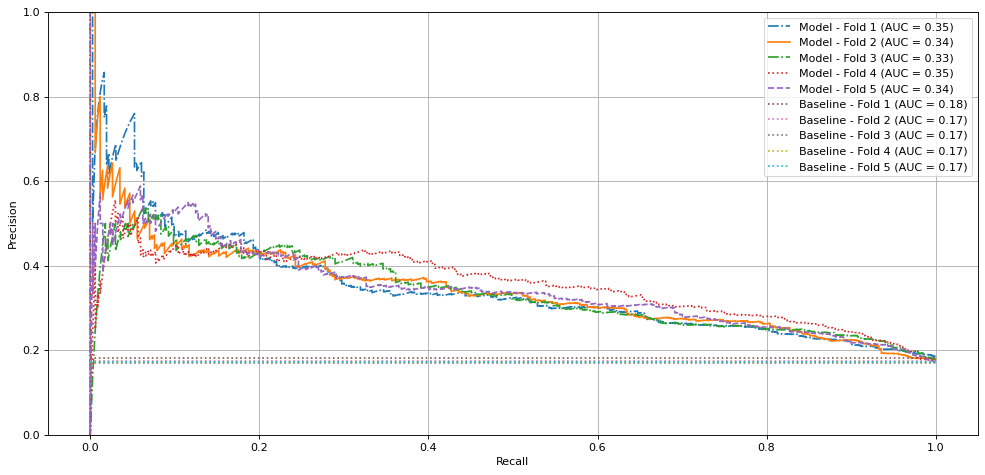

In [9]:
fig, ax = plt.subplots(figsize=(15, 7), dpi=80)

ax.set_ylim(ymin=0)

ax.plot(recall_list[0], precision_list[0], marker='', linestyle='-.', label='Model - Fold 1 (AUC = '+'{:.2f}'.format(auc_list_model[0])+')')
ax.plot(recall_list[1], precision_list[1], marker='', linestyle='-', label='Model - Fold 2 (AUC = '+'{:.2f}'.format(auc_list_model[1])+')')
ax.plot(recall_list[2], precision_list[2], marker='', linestyle='-.', label='Model - Fold 3 (AUC = '+'{:.2f}'.format(auc_list_model[2])+')')
ax.plot(recall_list[3], precision_list[3], marker='', linestyle=':', label='Model - Fold 4 (AUC = '+'{:.2f}'.format(auc_list_model[3])+')')
ax.plot(recall_list[4], precision_list[4], marker='', linestyle='--', label='Model - Fold 5 (AUC = '+'{:.2f}'.format(auc_list_model[4])+')')

ax.plot([0, 1], [no_skill_list[0], no_skill_list[0]], linestyle=':', label='Baseline - Fold 1 (AUC = '+'{:.2f}'.format(auc_list_no_skill[0])+')')
ax.plot([0, 1], [no_skill_list[1], no_skill_list[1]], linestyle=':', label='Baseline - Fold 2 (AUC = '+'{:.2f}'.format(auc_list_no_skill[1])+')')
ax.plot([0, 1], [no_skill_list[2], no_skill_list[2]], linestyle=':', label='Baseline - Fold 3 (AUC = '+'{:.2f}'.format(auc_list_no_skill[2])+')')
ax.plot([0, 1], [no_skill_list[3], no_skill_list[3]], linestyle=':', label='Baseline - Fold 4 (AUC = '+'{:.2f}'.format(auc_list_no_skill[3])+')')
ax.plot([0, 1], [no_skill_list[4], no_skill_list[4]], linestyle=':', label='Baseline - Fold 5 (AUC = '+'{:.2f}'.format(auc_list_no_skill[4])+')')

# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend()
plt.grid()

plt.show()

# SHAP
We are calculating SHAP values, giving us an idea about the feature importances in each of the five models.

In [10]:
# iterate through all folds and collect feature importances
cnt = 0

dict_fi_all_folds = {}

for r in rl:
    cnt += 1
    
    # load values of fold
    model = r.search.best_estimator_.named_steps.lgbm
    
    search = r.search
    y_test = r.y_test
    y_test_predict = r.y_test_predict
    X_test = r.X_test
    X_train = r.X_train
    y_train = r.y_train
    groups = r.groups
    y_df = r.y_df
    X_df = r.X_df
    train_index = r.train_index
    test_index = r.test_index
    cnt = r.cnt
    pipe = r.pipe
    searchspace = r.searchspace
    
    X_df_train = X_df.iloc[train_index]
    y_df_train = y_df.iloc[train_index]
    
    X_df_test = X_df.iloc[test_index]
    y_df_test = y_df.iloc[test_index]
    
    X_df_test = X_df_test.reset_index(drop=True)
    
    X = X_df
    
    # get SHAP feature importances
    print('Fold '+str(cnt))

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_df_test)
    
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X_df_train.columns, sum(vals))), columns=['col_name', 'feature_importance_vals'])
    feature_importance_sorted = feature_importance.sort_values(by=['feature_importance_vals'], ascending=False).head(20)
    dict_fi_curr = dict(feature_importance_sorted.values)
    dict_fi_all_folds = combine_dicts(dict_fi_all_folds, dict_fi_curr, operator.add)

Fold 1


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 2
Fold 3
Fold 4


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Fold 5


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [11]:
# SHAP feature importances summed up over all 5 folds

df_fi = pd.DataFrame.from_dict(dict_fi_all_folds, orient='index')
df_fi = df_fi.sort_values(by=[0], ascending=False)
df_fi.head(8)

,0
r_delta_f,5571.899980
r_craving_shifted_1,5441.458179
q_age,2867.675101
day_of_week,2737.972189
r_mood_valence_shifted_1,2107.751187
r_persevere_difficulty_shifted_1,1828.046851
q_city,1307.103039
r_persevere_motivation_2_shifted_1,1100.937416


We are going to use 6 of the overall most important features

Fold 1


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


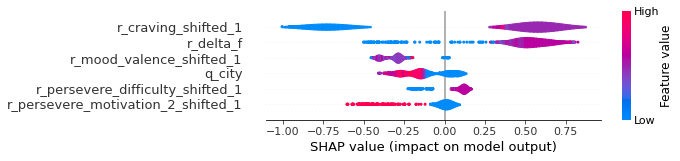

Fold 2


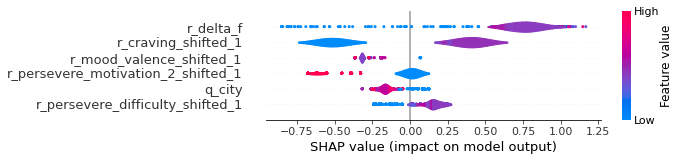

Fold 3


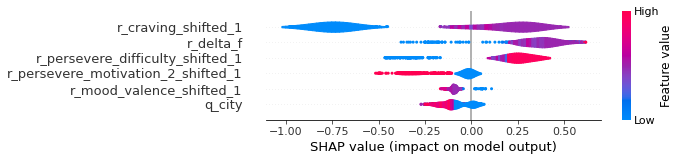

Fold 4


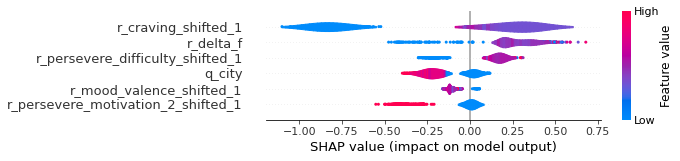

Fold 5


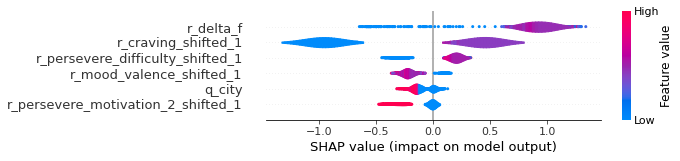

In [12]:
# plot shap summaries for features:
# r_delta_f, r_craving_shifted_1, r_mood_valence_shifted_1, r_persevere_difficulty_shifted_1, q_city, r_persevere_motivation_2_shifted_1

cnt = 0

for r in rl:
    cnt += 1
    
    # load values of fold
    model = r.search.best_estimator_.named_steps.lgbm
    
    search = r.search
    y_test = r.y_test
    y_test_predict = r.y_test_predict
    X_test = r.X_test
    X_train = r.X_train
    y_train = r.y_train
    groups = r.groups
    y_df = r.y_df
    X_df = r.X_df
    train_index = r.train_index
    test_index = r.test_index
    cnt = r.cnt
    pipe = r.pipe
    searchspace = r.searchspace
    
    X_df_train = X_df.iloc[train_index]
    y_df_train = y_df.iloc[train_index]
    
    X_df_test = X_df.iloc[test_index]
    y_df_test = y_df.iloc[test_index]
    
    X_df_test = X_df_test.reset_index(drop=True)
    
    X = X_df
    
    # plot SHAP summary plots
    print('Fold '+str(cnt))
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_df_test)
    
    # get index for columns:
    # r_delta_f, r_craving_shifted_1, r_mood_valence_shifted_1, r_persevere_difficulty_shifted_1, q_city, r_persevere_motivation_2_shifted_1
    r_delta_f_index = X_df_test.columns.get_loc('r_delta_f')
    r_craving_shifted_1_index = X_df_test.columns.get_loc('r_craving_shifted_1')
    r_mood_valence_shifted_1_index = X_df_test.columns.get_loc('r_mood_valence_shifted_1')
    r_perservere_difficulty_shifted_1_index = X_df_test.columns.get_loc('r_persevere_difficulty_shifted_1')
    q_city_index = X_df_test.columns.get_loc('q_city')
    r_perservere_motivation_2_shifted_1_index = X_df_test.columns.get_loc('r_persevere_motivation_2_shifted_1')
    
    indexes_to_keep = (r_delta_f_index, r_craving_shifted_1_index, r_mood_valence_shifted_1_index, r_perservere_difficulty_shifted_1_index,
                       q_city_index, r_perservere_motivation_2_shifted_1_index)
    
    indexes_to_keep_list = list(indexes_to_keep)
    
    shap.summary_plot(shap_values[1][:, indexes_to_keep_list], X_df_test.iloc[:, indexes_to_keep_list], plot_type="violin", plot_size=(7.5, 2.0))